#**Quantum System on Chip - Digital Twin model**

##Linsen Li and Dirk Englund

## V2023.12.18

Overview of the architecture system modeling:

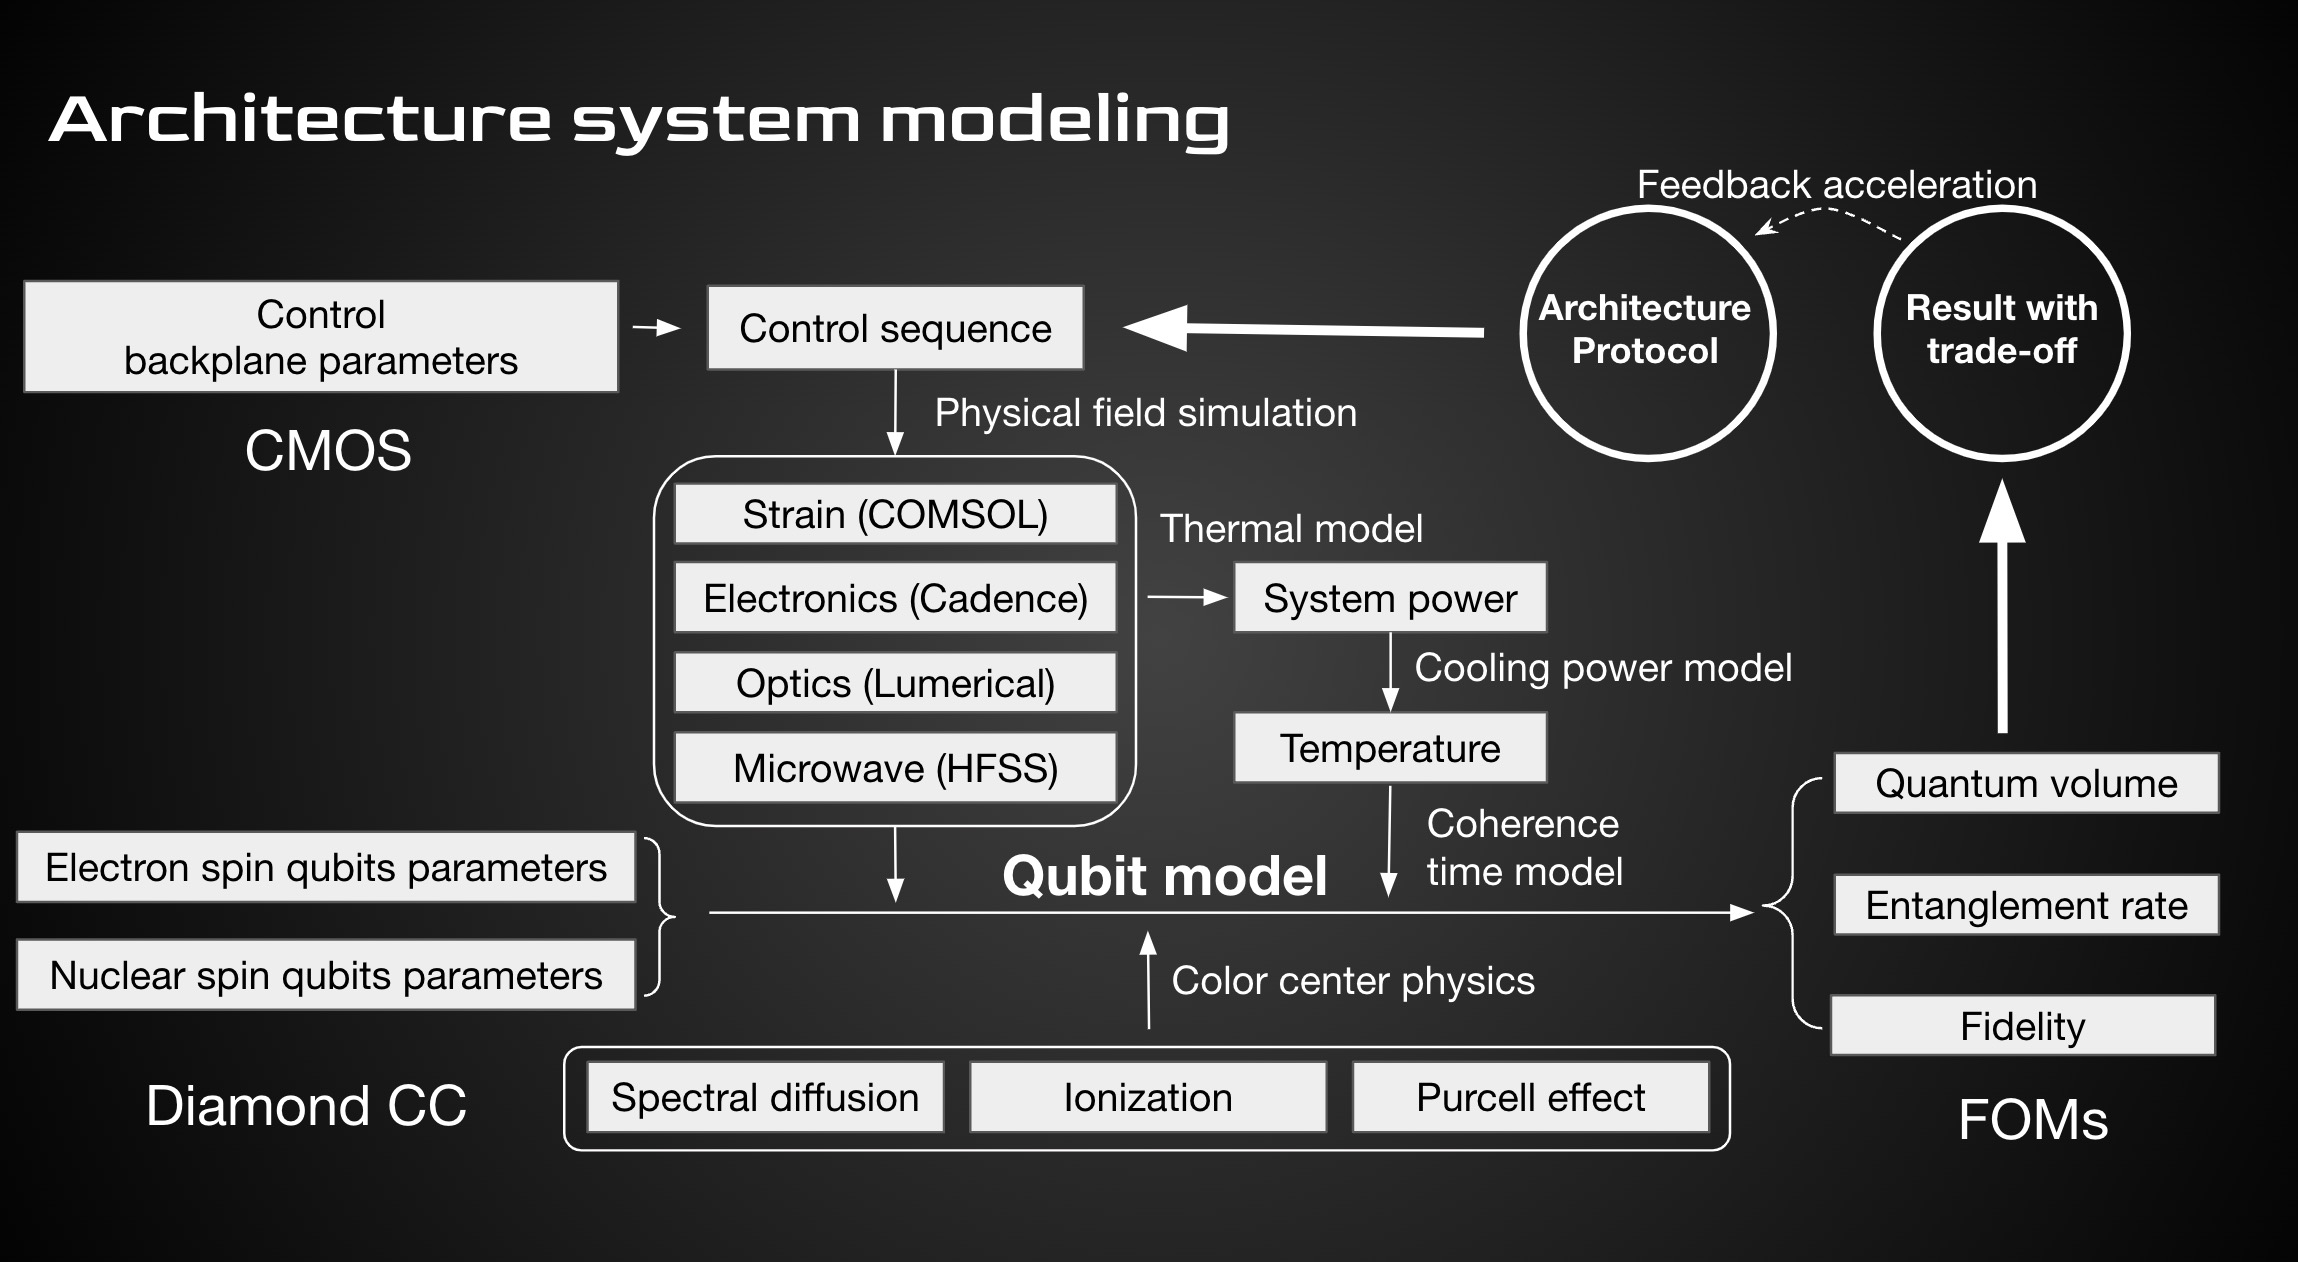

Architecture modeling outline: \\
1. Key parameters for general-purpose quantum computing
2. Architectural entanglement sequence for estimating entanglement rates
3. Spectral diffusion's impact on entanglement rate
4. Effect of spectral diffusion and Purcell enhancement on visibility
5. Strain tuning models for ZPL shift and spin splitting
6. Thermal budget considerations for the architecture's operation
7. Emitter statistical data (Need data file from the github repo: https://github.com/LinsenLi97/Freely-scalable-architecture-modeling)

**1. Key parameters for general-purpose quantum computing**

Parameter definition:
* $N_\text{qubit}$:  Number of the qubit in the system
* $N_\text{link}$: Averaged of the number of the qubit each qubit can interact to
* $T_2$: Electronic spin coherence $T_2$ time
* $T_0$: Electronic spin entanglement to nuclear spin entanglement delay time (Assume 5us here $^{[1]}$)
* $T_{nuclear}$ : Nuclear spin coherence $T_2$ time (Assume 1s here $^{[2]}$)
* $r_{ent}$: Entanglement generation rate
<!-- * $err_{ctr}$: Control error in the system -->
* $\epsilon_{dec}\approx 1-exp(-T_0/T_2)+1-exp(-1/r_{ent}T_{nuclear})$: Decoherence error in the system (electron spin transfer to nuclear spin docoherence and nuclear spin decoherence until another successful entanglement built)
* $log_2 QV_{max} = max(min(n,\frac{1}{n\epsilon_{dec}}))(n<N) ~^{[3]}$
* $N=\frac{1}{\sqrt{\epsilon_{dec}}}$ reaches the maximum quantum volume


[1]. Humphreys, Peter C., et al. "Deterministic delivery of remote entanglement on a quantum network." Nature 558.7709 (2018): 268-273.

[2]. Bradley, Conor E., et al. "A ten-qubit solid-state spin register with quantum memory up to one minute." Physical Review X 9.3 (2019): 031045.

[3]. Cross, Andrew W., et al. "Validating quantum computers using randomized model circuits." Physical Review A 100.3 (2019): 032328.



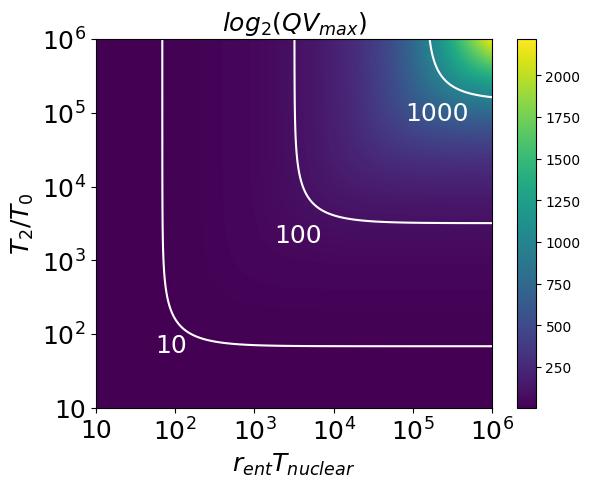

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize the QV matrix
QV = np.zeros((1001, 1001))

# Fill the QV matrix
for i in range(1001):
    for j in range(1001):
        errx = 0.1 * 10 ** (-6 * (i - 1) / 1000)
        erry = 0.1 * 10 ** (-6 * (j - 1) / 1000)
        QV[i, j] = np.sqrt(1 / (errx + erry))

# Plotting the image
plt.figure()
plt.imshow(QV, aspect='auto', origin='lower')
plt.colorbar()
contour_levels = [10, 100, 1000]
plt.contour(QV, contour_levels, colors='w')
plt.xticks([0, 200, 400, 600, 800, 1000], ['10', '$10^2$', '$10^3$', '$10^4$', '$10^5$', '$10^6$'])
plt.yticks([0, 200, 400, 600, 800, 1000], ['10', '$10^2$', '$10^3$', '$10^4$', '$10^5$', '$10^6$'])
plt.text(150, 150, '10', color='w', fontsize=18)
plt.text(450, 450, '100', color='w', fontsize=18)
plt.text(780, 780, '1000', color='w', fontsize=18)
plt.gca().tick_params(labelsize=18)
plt.xlabel('$r_{ent}T_{nuclear}$', fontsize=18)
plt.ylabel('$T_2/T_0$', fontsize=18)
plt.title('$log_2(QV_{max}$)', fontsize=18)
plt.show()


Here we are trying to utilize this model to provide prediction of the maximum quantum volume of the different color centers.

In the calculation, we are assuming using the commercial available cryostat with vector magnet: https://www.attocube.com/en/products/cryostats/closed-cycle-cryostats/attodry2100

(Cooling power: 2mW @ 2K, 900mW @ 4K)

We use the following information from section 6 that:
* The model of the temperature dependent $T_1$ time for SnV.
* The $T_2$ coherence time relation to $T_1$.
* The commercial thermal cooling power model relation to the temperature.
* The thermal budget of different heat source. The more qubit we use will heat the stage temperature that reduced the $T_2$ time.

We estimate the quantum volume with our compact QSoC architecture ($N_{mw}=100$) and the other architecture with large spacing the individual microwave control ($N_{mw}=1$)

The color center optical efficiency data citation:

SnV$^{[1]}$: 36%= 57% * 80% * 80% (quantum efficiency (80%), Debye-Waller factor (57%), branching ratio into the C transition (80%)).

SiV: 6.3% = 9% * 70% (quantum efficiency (9%)$^{[2]}$, Debye-Waller factor (70%) $^{[3]}$)

NV$^{[4]}$: 2.8% = 4% * 70% (quantum efficiency (70%), Debye-Waller factor (4%))

Si T-center: 2.8%$^{[5]}$ (Debye-Waller factor (23%)$^{[6]}$)

Ref:

[1]. Rugar, Alison E., et al. "Quantum photonic interface for tin-vacancy centers in diamond." Physical Review X 11.3 (2021): 031021.

[2]. Neu, Elke, Mario Agio, and Christoph Becher. "Photophysics of single silicon vacancy centers in diamond: implications for single photon emission." Optics express 20.18 (2012): 19956-19971.

[3]. Dietrich, Andreas, et al. "Isotopically varying spectral features of silicon-vacancy in diamond." New Journal of Physics 16.11 (2014): 113019.

[4]. Aharonovich, I., et al. "Diamond-based single-photon emitters." Reports on progress in Physics 74.7 (2011): 076501

[5]. Lee, Chang-Min, et al. "High-efficiency single photon emission from a silicon T-center in a nanobeam." ACS Photonics (2023).

[6]. Bergeron, L., et al. "Silicon-integrated telecommunications photon-spin interface." PRX Quantum 1.2 (2020): 020301.



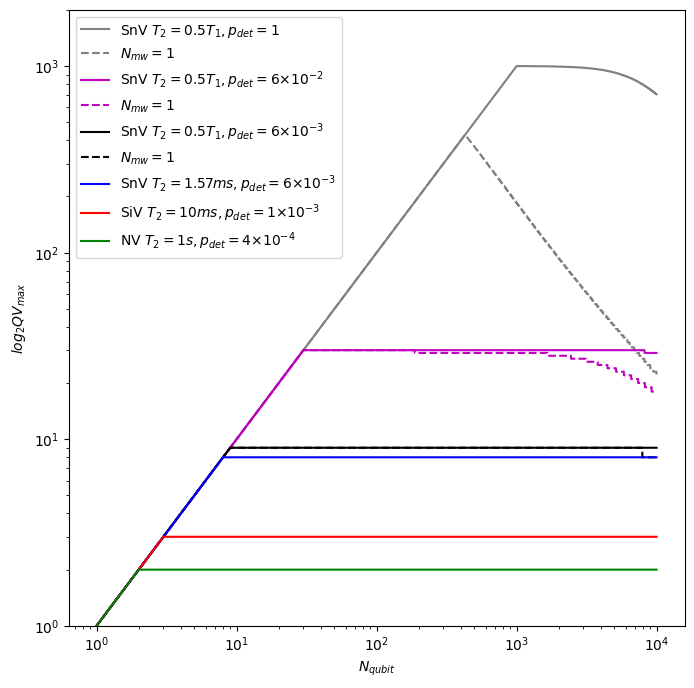

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

n = 10000 # How many qubit we want to plot in the curve.
log2QVmax = np.zeros(n) # Initialize the log_{2}QV_{max} variable.

# Global parameters
Topr = 5e-6 # Gate time for the entanglement transfer between the electron spin and nuclear spin
Tnuclear = 1 # Nuclear spin T2 coherence time

# Thermal budget for the cryostat, see the definition in section 5 later. When different assumption is changed for the system can directly tuning different parameters value
P1 = 34 # nW; Optical control power/qubit
P2 = 88 # nW; Single qubit gate microwave control power/qubit
P3 = 27 # nW; Strain tuning for ZPL shifting power/qubit
P4 = 7 # nW; CMOS SPI power/qubit
P5 = 5000 # nW; Dynamic decoupling power/qubit (Microwave control always on)

#P1 calculation
Popt = 68; # Averaged optical power required for driving a qubit (Sequence dependent, see section 2 for sequence definition)
alpha = 0.5; # absorption (Using copper backplane optical absorption rate of ~50% in 532-620nm)
P1 = alpha*Popt # Calculate the P1

#P2 microwae control power calculation
k0 = 0.0176 # single qubit gate ratio for P2 (Sequence dependent, see section 2 for sequence definition)
P2 = k0*P5 # P2 power is proportional to the P5

#P3 calculation with CMOS strain tuing parameters
Cp = 2 #pF; Capacitance of each quantum channel
Vmax = 40 # V; Maximum voltage
f1 = 100 # Hz; Strain refresh rate
P3 = Cp*Vmax*Vmax*f1/12*1e-3 # nW ~27

#P4 is directly from cadence simulation, circuit design dependent, and bit rate dependent, assuming f2 = 100kbps for per qubit

#P5 (This will affect the power a lot for the microwave control using CMOS wiring parameters)
I = 1.27 #mA (Current required for microwave control, based on magnetific field simulation for our QSoC structure and experiment microwave control data in [1])
rho = 1e-9 # Ω⋅m ; we assume a normal copper with RRR(300K)/RRR(4K)=17, if an oxide free copper is used it can be further decrease resistivity.
L = 3e-3 # m ; our QSoC gds design
W = 1e-6 # m ; our QSoC gds design
H = 1e-6 # m ; The TSMC Metal layer thickness for our CMOS backplane
R = rho*L/(W*H) # The resistance of the microwave line
Rvia = 0.05 # Ω, The via resistance on the CMOS chip
Rbonding = 0.05 # Ω, The wire bonding resistance
DT = 1 # Duty cycle
P5 = I*I*(R+Rvia+Rbonding)*DT*1000 # nW ~5000

# Cryostat cooling line parameters (Assuming log(Cooling power) vs log(Temperature) is a linear function, related details in section 6 later, PL, PLT, PH, PHT can be changed for different cryostat.)
# Using Attodry cryostat providing cooling power 2mW @ 2K, 900mW @ 4K as parameters example here
PL = 2 #(mW)
PLT = 2 #(K)
PH = 900 #(mW)
PHT = 4 #(K)

# Define a function to avoid repeating the same code
def calculate_log2QVmax(Nmw, r, linestyle, color):
    for i in range(1, 10001):
        ThermQ = (i * (P1 + P3 + P4) + (P2 + P5) * np.ceil(i / Nmw))  * 1e-6 # Get the total cooling power required for the system sweeping from 1 qubit to 10000 qubit.
        Temp = np.exp((np.log(ThermQ) - np.log(PL)) / (np.log(PH) - np.log(PL)) * (np.log(PHT) - np.log(PLT)) + np.log(PLT)) # Calculating the cyrostate temperature based on cooling power required.
        T1 = (np.exp(40.8 / Temp) - 1) / 2.7 * 1e-8 # Get the T1 value of SnV using the T1 - temp modeling in section 6 later.
        T2 = 0.53 * T1 # Using the T2 value limited by the T1, more details in section 6 later

        err = (1 - np.exp(-Topr / T2)) + 1 - np.exp(-1 / (r * Tnuclear)) # Decoherence error for spin to nuclear conversion + nuclear spin decoherence when waiting for next entanglement done
        m = int(1 / np.sqrt(err)) # Quantum volume turning point (Heating of the cyrostat will reduce the turning point position)
        log2QVmax[i - 1] = min(i-1, m) # Maximum Quantum volume calculation

    plt.plot(log2QVmax, linestyle=linestyle, color=color) # plot the relation of the number of qubit vs the log_{2}QV_{max}

# Plotting
plt.figure(figsize=(12, 8))

# Parameter tuning for the plot
Nmw1 = 100 # 100 emitters shared a microwave line control
Nmw2 = 1 # each emitter has its own microwave line control
rent1 = 1000000 # Entanglement generation rate of 1MHz
rent2 = 900 # Entanglement generation rate of 900Hz
rent3 = 90 # Entanglement generation rate of 90Hz

# SnV, 100 quantum emitters shares the same microwave control, with entanglement generation of r_{ent}=1MHz (p_{det} =1, trial repitition rate with 2MHz)
calculate_log2QVmax(Nmw1, rent1, '-', [0.5, 0.5, 0.5])# grey solid line

# SnV, 1 quantum emitters per microwave line (individual control), with entanglement generation of r_{ent}=1MHz (p_{det} =1, trial repitition rate with 2MHz)
calculate_log2QVmax(Nmw2, rent1, '--', [0.5, 0.5, 0.5])# grey dash line

# SnV, 100 quantum emitters shares the same microwave control, with entanglement generation of r_{ent}=900Hz (p_{det} =0.06, trial repitition rate with 200kHz)
calculate_log2QVmax(Nmw1, rent2, '-', 'm')# magnet solid line

# SnV, 1 quantum emitters per microwave line (individual control), with entanglement generation of r_{ent}=900Hz (p_{det} =0.06, trial repitition rate with 200kHz)
calculate_log2QVmax(Nmw2, rent2, '--', 'm') # magnet dash line

# SnV, 100 quantum emitters shares the same microwave control, with entanglement generation of r_{ent}=90Hz (p_{det} =0.006, trial repitition rate with 200kHz)
calculate_log2QVmax(Nmw1, rent3, '-', 'k') # black solid line

# SnV, 1 quantum emitters per microwave line (individual control), with entanglement generation of r_{ent}=90Hz (p_{det} =0.006, trial repitition rate with 200kHz)
calculate_log2QVmax(Nmw2, rent3, '--', 'k') # black dash line

# Additional plots with different T2 and r values
T2_values = [1.57e-3, 13e-3, 1] #[1]: SnV T2 1.57ms @ 1.7K; [2]: SiV T2 13ms @ 100mK; [3]: NV T2 1s @ 4.3K
r_values = [90, 15, 6] # Entanglement generation rate estimation based on the ratio of ZPL optical efficiency, NV has a 2% ZPL optical efficiency (6Hz entanglement rate demonstrated [4]), SiV has a 5% ZPL optical efficiency, SnV hasa a 30% ZPL optical efficiency
colors = ['b', 'r', 'g']

# plot the log2QVmax with reference T2 data and estimated entanglement generation rate based on different color center's optical efficiency
for T2, r, color in zip(T2_values, r_values, colors):
    err = (1 - np.exp(-Topr / T2)) + 1 - np.exp(-1 / (r * Tnuclear))
    m = int(1 / np.sqrt(err))
    log2QVmax = np.ones(n) * m
    log2QVmax[:m] = np.arange(0, m)
    plt.plot(log2QVmax, color=color)

# Setting the legend, scales, labels, and limits
plt.legend(['SnV $T_2=0.5T_1,p_{det}=1$', '$N_{mw}=1$', 'SnV $T_2=0.5T_1,p_{det}=6×10^{-2}$', '$N_{mw}=1$', 'SnV $T_2=0.5T_1,p_{det}=6×10^{-3}$', '$N_{mw}=1$', 'SnV $T_2=1.57ms, p_{det}=6×10^{-3}$', 'SiV $T_2=10ms, p_{det}=1×10^{-3}$', 'NV $T_2=1s, p_{det}=4×10^{-4}$'])
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().set_box_aspect(1)
plt.xlabel('$N_{qubit}$')
plt.ylabel('$log_{2}QV_{max}$')
plt.ylim([1, 2e3])
plt.show()

# T2 reference
# [1]. Guo, Xinghan, et al. "Microwave-Based Quantum Control and Coherence Protection of Tin-Vacancy Spin Qubits in a Strain-Tuned Diamond-Membrane Heterostructure." Physical Review X 13.4 (2023): 041037.
# [2]. Sukachev, Denis D., et al. "Silicon-vacancy spin qubit in diamond: a quantum memory exceeding 10 ms with single-shot state readout." Physical review letters 119.22 (2017): 223602.
# [3]. Abobeih, Mohamed H., et al. "One-second coherence for a single electron spin coupled to a multi-qubit nuclear-spin environment." Nature communications 9.1 (2018): 2552.



**2. Architectural entanglement sequence for estimating entanglement rates**

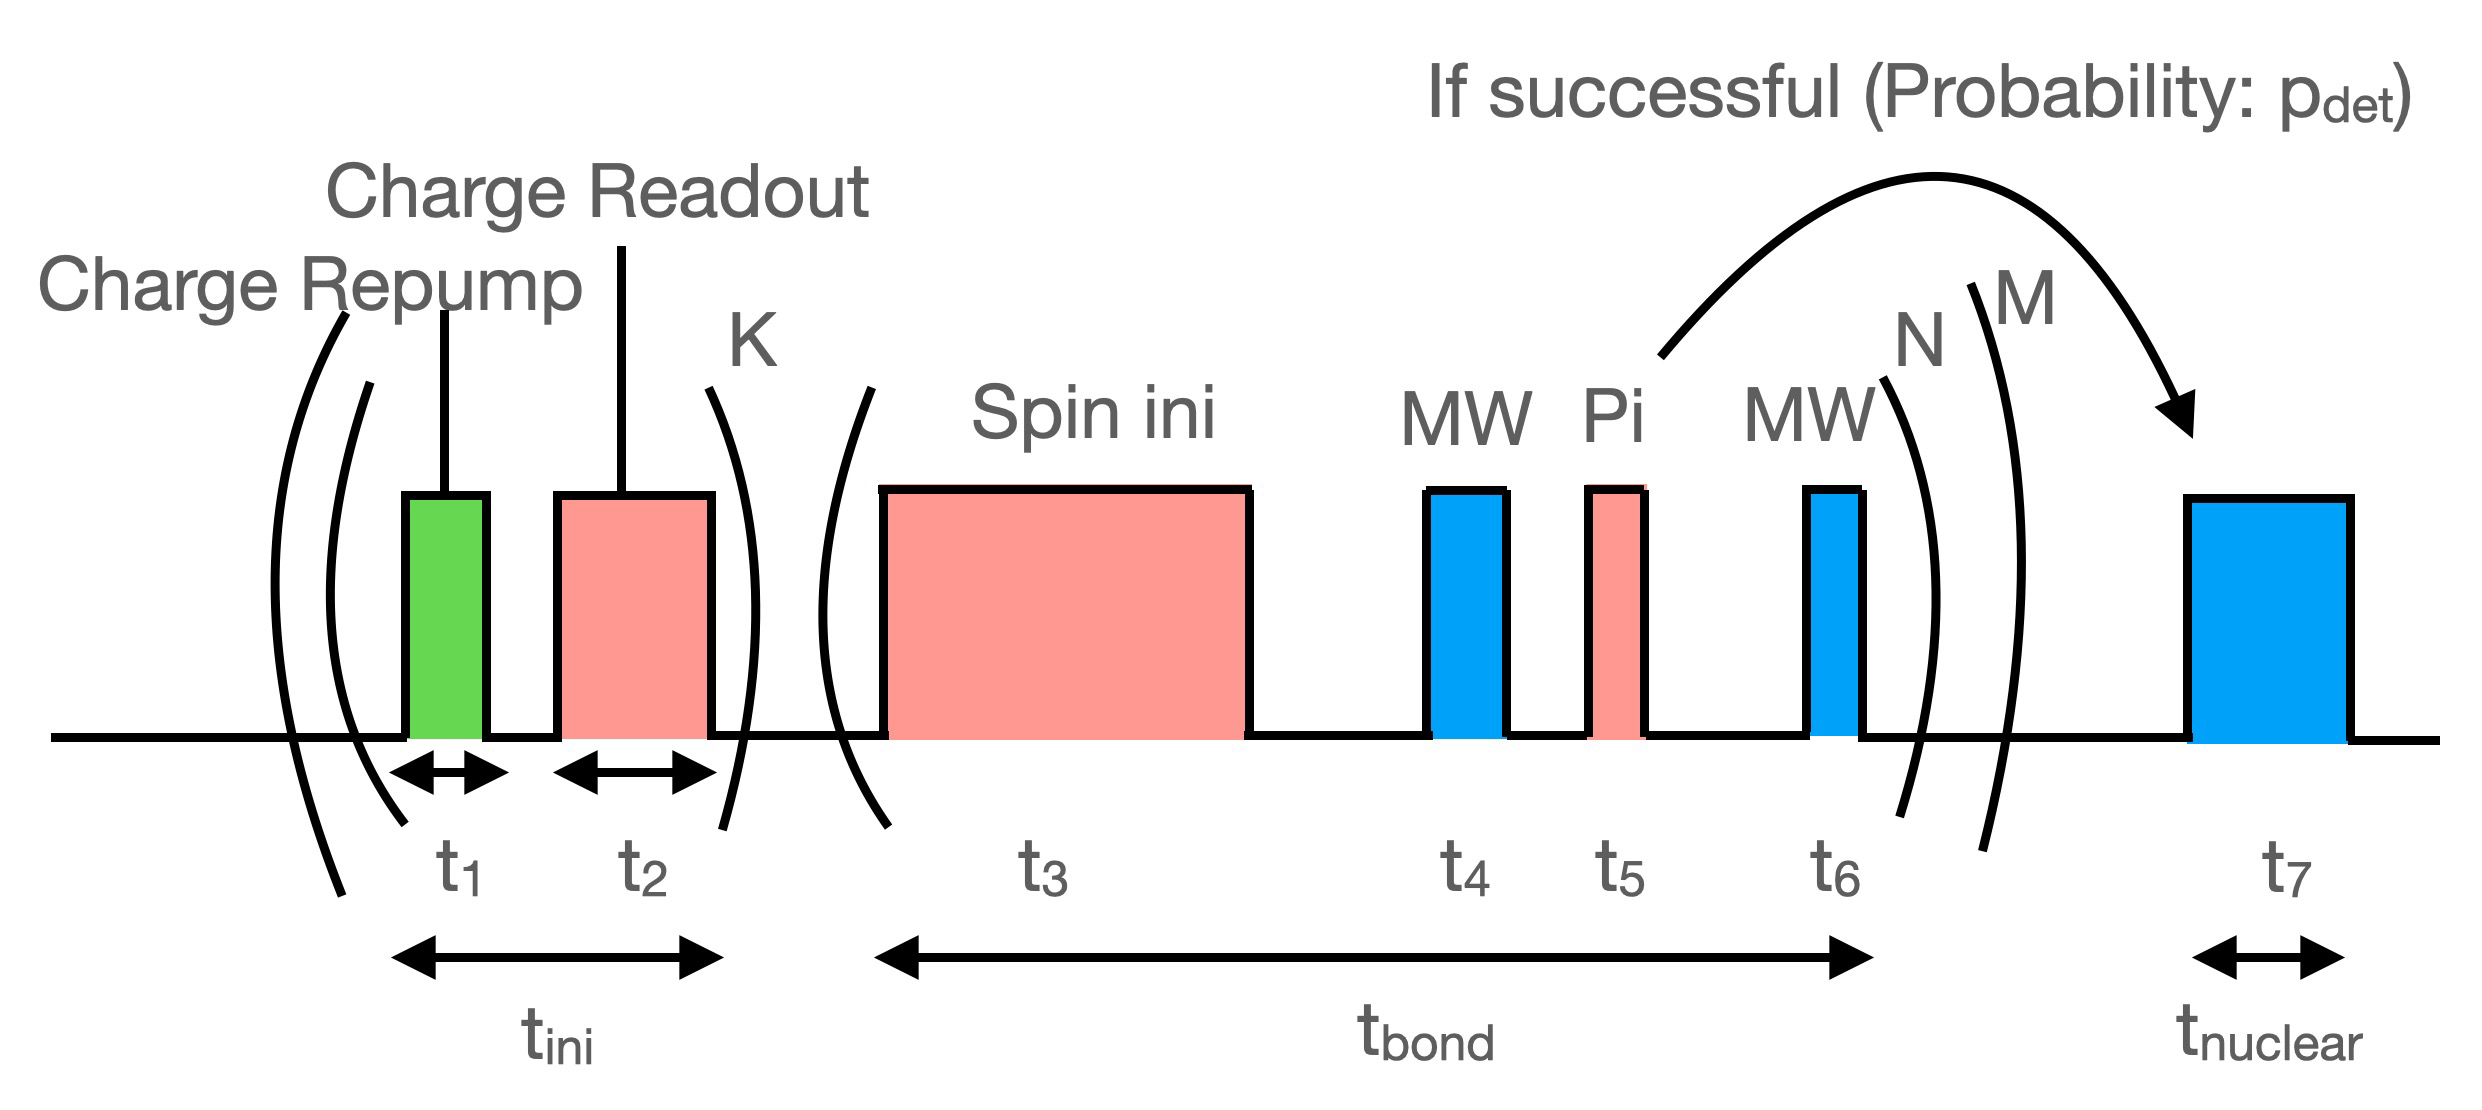


Control sequence definition:

* Green background pulse: green repump laser on
* Red background pulse: red repump laser on
* Blue background pulse: microwave control on

Assuming one of the spin state like |0⟩ is tuned to resonantly align the laser while the other spin state |1⟩ is off-resonant with the laser.

Charge initialization sequence related parameters:
* $t_{1}$: Charge repump time with repump laser on (532nm repump laser in our
architecture instance)
* $t_{2}$: Charge readout time to check the emitter in the correct charge state
* $t_{ini} \approx t_{1}+t_{2}$: Charge initialization time for confirming the emitter is in the correct charge state
* $C_{th}$: The threshold photon count measured by the single photon detector for claiming a successful charge initialization during the $t_{2}$ time
* K: Charge initialization check repeatition time until the successful charge initialization

Entanglement sequence related parameters for single photon herald entanglement protocal:
* $t_{3}$: Spin initialization, resonant laser align with the spin state |0⟩, so initalize the spin state to |1⟩
* $t_{4}$: Microwave control signal to drive the quantum state to
$|\psi⟩=\sqrt{1-\alpha} |1⟩+\sqrt{\alpha}|0⟩  $
* $\alpha$: The error rate of the single photon herald entanglement protocal
* $t_{5}$: Optical $\pi$ pulse for ZPL photon emission (with probability $p_{det}$ to get detected by the single photon detector)
* $t_{6}$: Microwave control to go back to spin state |1⟩
* $t_{bond}\approx t_3+t_4+t_5+t_6$: Herald engtanglement trial time
* N: Herald entanglement trial repetition time
* $p_{det}$: Successful probability of single photon detector detect a single photon from the quantum emitter.
* $r_{ion}$: Ionization rate of the quantum emitter goes to the charge state in the control pulse sequence.
* M: Charge repump repetition time to repetitely apply the repump sequence to get the quantum emitter back to the correct charge state.

Once we applying the single photon herald entanglement protocal, and see a single photon detection click, we build the successful herald entanglement. The overall successful probability:

* $p_{success} = 2\alpha p_{det}$ (Single photon protocal)

After we build the successful herald entanglement we will transfer the electron spin entanglement to the nuclear spin， having the related parameters:

* $t_7$: Microwave control two qubit gate for electron spin to nuclear spin

Entanglement rate estimation:

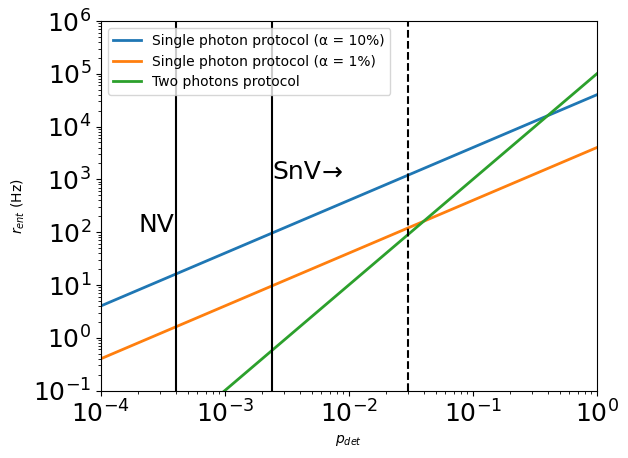

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Data generation
x = np.arange(1e-4, 1 + 1e-4, 1e-4)
y = 2 * 0.1 * x / (5e-6)

# Plotting
plt.figure()
h1, = plt.loglog(x, y, linewidth=2, label='Single photon protocol (α = 10%)')
h2, = plt.loglog(x, 0.1 * y, linewidth=2, label='Single photon protocol (α = 1%)')
h3, = plt.loglog(x, x * x / (2 * 5e-6), linewidth=2, label='Two photons protocol')

# Lines and Text
plt.axvline(x=3e-2, color='k', linestyle='--')
plt.axvline(x=2.4e-3, color='k')
plt.axvline(x=4e-4, color='k')
plt.text(2e-4, 100, 'NV', fontsize=18)
plt.text(2.4e-3, 1000, 'SnV', fontsize=18)
plt.text(6e-3, 1000, '→', fontsize=18)

# Axes and labels
plt.xlabel('$p_{det}$')
plt.ylabel('$r_{ent}$ (Hz)')
plt.ylim([1e-1, 1e6])
plt.xlim([1e-4, 1])
plt.gca().tick_params(labelsize=18)
plt.legend(loc='upper left')

plt.show()

**3. Spectral diffusion's impact on entanglement rate**

We assume $r_{ion} =$ 100 Hz, 50 Hz, and 10 Hz here, corresponding to $t_{ini}+t_{bond} = $ 10 ms, 20 ms, 100 ms.

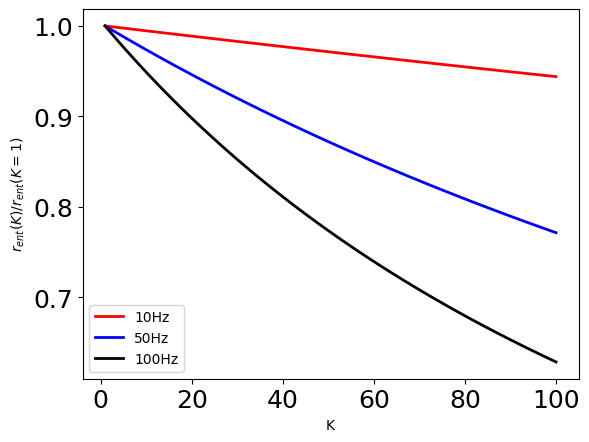

In [ ]:
import matplotlib.pyplot as plt

# Values for t
t_values = [100, 20, 10]
colors = ['r', 'b', 'k']  # red, blue, black
labels = ['10Hz', '50Hz', '100Hz']  # labels for legend

# K range
K = range(1, 101)

plt.figure(3)
for t, color, label in zip(t_values, colors, labels):
    plt.plot(K, [(t +  0.06) / (t + k * 0.06) for k in K], color, linewidth=2, label=label)

# Legend, labels, and formatting
plt.legend(loc='lower left')
plt.xlabel('K')
plt.ylabel('$r_{ent}(K)/r_{ent}(K=1)$')
plt.gca().tick_params(labelsize=18)
plt.box(on=True)
plt.show()

**4. Effect of spectral diffusion and Purcell enhancement on visibility**

Parameter definition:
* $\Gamma$: Transform limited linewidth
* $\Delta$: Central wavelength detuning of two emitters
* $F_p$: Purcell Factor
* $V$: Interference visibility of two quantum emitters

Fidelity of the two-qubit gate limited by the visibility: F=(1+$\sqrt{V}$)/2


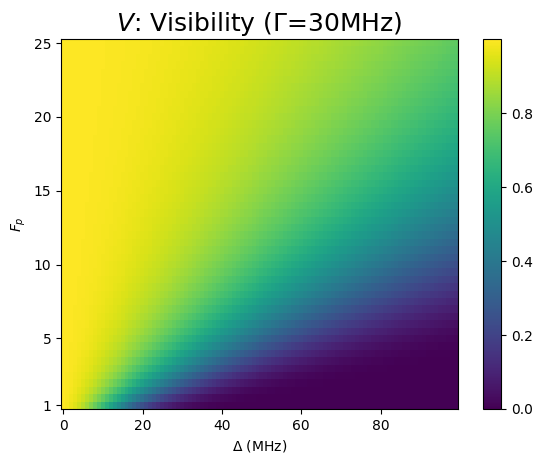

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generating x values
x = np.arange(1, 2000001)  # 2 GHz; 30 MHz * 3

# Initialize matrix V
V = np.zeros((50, 100))

# Calculating V
for i in range(1, 51):
    for j in range(1, 101):
        b = j
        a = 3.742 * (1 / 5.56 + 0.36 / 4.12 * i * 0.5)
        y1 = np.exp(-((x - 1000000) / (15000 * a)) ** 2)
        y2 = np.exp(-((x - 1000000 - b * 1000) / (15000 * a)) ** 2)
        V[i - 1, j - 1] = np.dot(y1, y2) / np.dot(y1, y1)

# Plotting
plt.figure()
plt.imshow(V, aspect='auto', origin='lower')
plt.colorbar()
plt.xlabel('$\Delta$ (MHz)')
plt.ylabel('$F_p$')
plt.yticks([0, 9, 19, 29, 39, 49], ['1', '5', '10', '15', '20', '25'])
plt.title('$V$: Visibility ($\Gamma$=30MHz)', fontsize=18)
plt.show()


**5. Strain tuning models for ZPL shift and spin splitting**

We using the numerical simulation modeling to estimate the transverse strain impact on the absolute frequency shifting and the spin transition splitting.

Parameters:
* B: Magnetic field
* $\Delta E$: Spin energy splitting
* $\Delta f$: Frequency shifting
* $\varepsilon_t$: Transverse strain
* $\varepsilon_l$: Longitute strain
* $\theta$: Angle between magnetic field and dipole

Strain simulation code:

In [ ]:
import numpy as np
# Group IV-Vacancy Properties
# Hamiltonian parameters
defect = [f'$^{{29}}$SiV$^–$', f'$^{{73}}$GeV$^–$', f'$^{{117}}$SnV$^–$']
qs = [0.1, 0.125, 0.171] # [] orbital magnetic field susceptiblity
qs_exc = [0.1, 0.125, 0.073] # [] orbital magnetic field susceptiblity
Ls = [46, 181, 830] # [GHz] spin orbit coupling gnd state
L_excs = [260, 1120, 3000] # [GHz] spin orbit coupling exc state

# Strain susceptibilities
# SiV from experiment (Meesala et al. P.R.B. (2018) https://journals.aps.org/prb/abstract/10.1103/PhysRevB.97.205444)
# GeV assumed same as SiV
# SnV from DFT (Guo et al. arxiv:2307.11916 (2023) https://arxiv.org/abs/2307.11916)
d = [1.3e6, 1.3e6, 0.787e6]     # [GHz/strain]
d_err = [0.1e6, 0.1e6, 0.1e6] # [GHz/strain]
f = [-1.7e6, -1.7e6, -0.562e6]  # [GHz/strain]
f_err = [0.1e6, 0.1e6, 0.1e6] # [GHz/strain]

# Group IV-Vacancy Hyperfine Properties: gnd DFT hyperfine for Sn-117
S = 1/2

# Electron parameters
be = 9.2740100783e-24 # [J/T] # Bohr magneton
ge = 2.0023 # electron g factor
h = 6.626e-34 # [J*s] Plank constant
T_to_GHz = ge*be/h/1e9 # [GHz/T] Conversion from T to GHz

# Hamiltonians
# Spin matrices formula from: https://easyspin.org/easyspin/documentation/spinoperators.html
Sx = lambda S: 1/2*np.array([ [ np.sqrt((S*(S+1)) - (-S + m)*(-S + n)) if m==(n+1) or (m+1)==n else 0 for n in range(round(2*S+1))] for m in range(round(2*S+1))])
Sy = lambda S: 1/(2*1j)*np.array([ [ (-1)**(m>n)*np.sqrt((S*(S+1)) - (-S + m)*(-S + n)) if m==(n+1) or (m+1)==n else 0 for n in range(round(2*S+1))] for m in range(round(2*S+1))])
Sz = lambda S: np.diag(np.arange(S,-S-0.5,-1))

def create_hamiltonian():
    """Create a Hamiltonian for the group IV color center spin-orbit system"""
    S = 1/2
    X = Sx(S)
    Y = Sy(S)
    Z = Sz(S)
    I = np.eye(round(2*S+1),round(2*S+1))

    # Magnetic field on electron (not no factor of 1/2 needed for electron spin since it is cancelled by g~2)
    Hbxe = lambda bx: bx*np.kron(I, X)
    Hbye = lambda by: by*np.kron(I, Y)
    Hbze = lambda bz: bz*np.kron(I, Z)

    # Magnetic field on orbital degree of freedom
    Hbzo = lambda bz, q: q*bz*np.kron(Z, I)

    # SOC
    Hsoc = lambda L: 2*L*np.kron(Z,Z) # factor of 2 since each Z has a factor of 1/2

    # Strain/JT
    Hegx = lambda alpha: -2*alpha*np.kron(X, I)
    Hegy = lambda  beta:  -2*beta*np.kron(Y, I)

    # dipole moment operators [px, py, pz]
    T = np.array([[-1,-1j],[1,-1j]]).transpose()/np.sqrt(2)
    p = [     # egx/y => eg+/-
        2*Z,  #   Z   =>  -X
        -2*X, #   X   =>  -Y
        I     #   I   =>   I
    ]
    p = [np.einsum('ji,jk,kl->il',T.conj(),x,T) for x in p]
    p = np.array([np.kron(x, I) for x in p]) # index (polarisation, i, j)

    # Total Hamiltonian
    Href = lambda L, alpha, beta: Hsoc(L) + Hegx(alpha) + Hegy(beta) # Reference Hamiltonian including only strain & SOC
    H = lambda bx, by, bz, q, L, alpha, beta, g=ge, delta=0: Href(L, alpha, beta) + g/ge*Hbxe(bx) + g/ge*Hbye(by) + g/ge*(1+2*delta)*Hbze(bz) + Hbzo(bz,q) # Total Hamiltonian

    return H, Href, p

def tensor_repeat(*variables_1d):
    """Take one-dimensional arrays and puts them into arrays that all have the same shape, with orders of indicies corresponding to order of variables"""

    # Find shape to reshape variables in to
    shapes = [list(np.array(variable).shape) for variable in variables_1d]
    new_shape = []
    for shape in shapes:
        new_shape += shape
    ndim = len(new_shape)

    # Reshape all variables
    current_dim = 0
    variables_1d = list(variables_1d)
    for i, shape in enumerate(shapes):
        n = len(shape)
        repeat_axis = list(range(current_dim)) + list(range(current_dim+n, ndim))
        variables_1d[i] = np.expand_dims( variables_1d[i], axis=repeat_axis )

        for axis in repeat_axis:
            variables_1d[i] = np.repeat( variables_1d[i], new_shape[axis], axis=axis )

        current_dim += n

    return tuple(variables_1d)

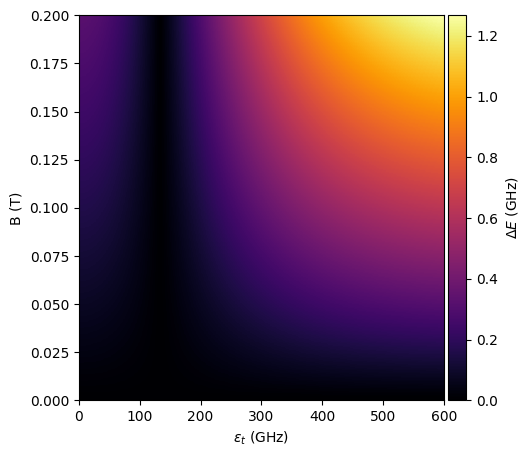

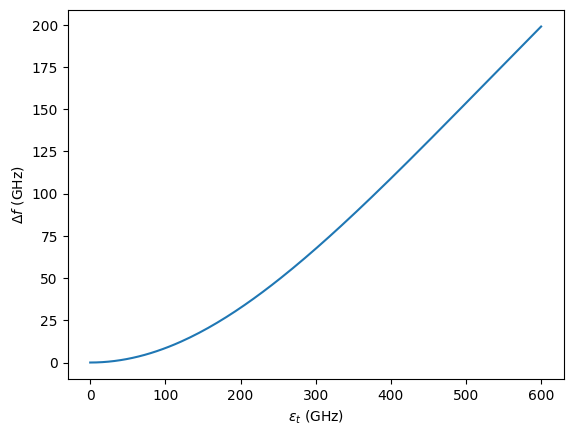

In [ ]:
import numpy as np
import sys
import matplotlib.pyplot as plt

H_SnV, _, p = create_hamiltonian()

B = np.linspace(0, 0.2, 100) # set the magnetic field range
alpha = np.linspace(0, 600, 150) # set the max strain range to display

thetaH = 54*np.pi/180 # set the dipole angle to the magnetic field
alpha_ratio = 1

BH, alpha_gnd, _ = tensor_repeat( B * T_to_GHz, alpha, np.zeros((4,4)))

bx = BH*np.sin(thetaH)
by = 0
bz = BH*np.cos(thetaH)

alpha_exc = alpha_gnd*alpha_ratio


Hgnd = H_SnV( bx, by, bz, qs[2], Ls[2], alpha_gnd, 0 )
Hexc = H_SnV( bx, by, bz, qs_exc[2], L_excs[2], alpha_exc, 0 )

Egnd, _ = np.linalg.eigh( Hgnd )
Eexc, _ = np.linalg.eigh( Hexc )

spin_splitting = (Eexc[...,1] - Egnd[..., 1]) - (Eexc[...,0] - Egnd[..., 0])
ple_shift = ( (Eexc[...,1] - Egnd[..., 1]) + (Eexc[...,0] - Egnd[..., 0]) )/2

fig = plt.figure(figsize=(5,5))
gs = plt.GridSpec(ncols=2, nrows=1, wspace=0.02, hspace=.5, width_ratios=[1,0.05])

vmax = 1

plt.subplot(gs[0,0])
im = plt.imshow( np.abs( spin_splitting ), extent=[alpha[0], alpha[-1], B[0], B[-1]], origin='lower', aspect='auto', cmap='inferno' )
plt.xlabel(r'$\varepsilon_t$ (GHz)')
plt.ylabel('B (T)')

cbar_ax = plt.subplot(gs[0,-1])
cbar = plt.colorbar(im, cax=cbar_ax)
cbar.set_label(r'$\Delta E$ (GHz)')

plt.show()

plt.plot( alpha, ple_shift[0,:] - ple_shift[0,0] )
plt.xlabel(r'$\varepsilon_t$ (GHz)')
plt.ylabel(r'$\Delta f$ (GHz)')
plt.show()

**6. Thermal budget considerations for the architecture's operation**

Thermal budget estimation related model parameters:

* $P_{repump}$   : Repump laser power (We use 0.7uW as an instance here)
* $P_{res}$: Resonant laser power for saturaly driving a quantum emitter (We use 0.1uW as an instance here)
* $P_{MW}$: Microwave power control for spin control (Using the reference $^{[1]}$, 1.6mT microwave peak magnetic field for rabi frequency 22MHz for SnV$^-$)
* $P_{nuclear}$ : Microwave power control for nuclear spin (Using the reference $^{[2]}$, the nuclear spin control amplitude is less than 10 times of the microwave control amplitude of the SnV nuclear spin control $^{[2]}$, used as the upper limit restriction)
* $N_{MW}$: Number of the quantum emitters shared the same microwave line (Our calculated resonant emitters in a quantum channel $n_{emitter}$ is 2.9, so we assume a $N_{MW}=3$ if the microwave only control a single quantum channel. If the microwave is controlling more than 1 channels $N_{MW}$ will further mutiply by the number of channel.
* $C_p$ : The capacitance for per qubit channel for holding the voltage (We use 2 pF as an instance here)
* $V_{max}$ : The maximum voltage applied to the CMOS. (We use 40 V as an instance here)
* $\alpha_{opt}$: The optical absorption rate of the substrate. (We use $\alpha_{opt}=50\%$ to represent the copper absorption around the 532nm and 620nm)

And we estimate our power budget
$P_{tot}=(P_1+P_2+P_3+P_4+P_5)\times N_{qubit}$
 from different aspect as:
* $P_1=P_{optical}$ : The averaged optical power per qubit heat the cryostat, scaling as the $N_{qubit}$
* $P_2=P_{microwave}$ : The averaged microwave power per qubit heat the cryostat, scaling as the $N_{qubit}$
* $P_3=P_{tuning}$ : The averaged CMOS tuning power per qubit to align the emitter to the resonant, scaling as the $N_{qubit} \times r_{ent}$
* $P_4=P_{SPI}$ : The averaged CMOS SPI communication power per qubit, scaling as the $N_{qubit} \times r_{ent}$
* $P_5=P_{DD}$: The dynamic decoupling power per qubit (the always on dynamic decoupling can extend the longest $T_2$ time but will heat the cryostat with the $P_{MW}$ for the microwave line)

Here is the equation for calculating these four aspect of the power:
* $P_{optical} = \alpha_{opt} \frac{(P_{repump}*t_1 + P_{res}*t_2)*K*M+P_{res}*(t_3+t_5)*N*M}{t_{ini}*K++t_{bond}*N)*M+t_7}$

* $P_{microwave} = \frac{P_{MW}/N_{MW} * (t_4+t_6)*N*M + P_{nuclear}*t_7}{(t_{ini}*K++t_{bond}*N)*M+t_7}$

* $P_{tuning}=\frac{1}{12}C_pV_{max}^2 f$ : assuming a uniform ditribution from 0V to the maximum voltage $V_{max}$ applied to each quantum channel, the averaged tuning voltage introduced thermal dissipation into the system. (f is considered as 100Hz here for the expected entanglement generation rate)

* $P_{SPI} = P_{sim} $

* $P_{DD} = \frac{P_{MW}}{N_{MW}}$

Microwave power estimation model:
* $P_{MW} = I^2R$
* $R=\rho \times \frac{L}{W \times h}$ (We use $\rho=10^{-9}\Omega \cdot m$ here, assuming $RRR=\rho(300K)/\rho(4K)=17$)
* L: The length of the microwave line (We use 3mm as the instance here)
* W: The width of the microwave line (We use 1um as the instance here)
* h: The thickness of the microwave line (We use 1um as the instance here)

[1]. Rosenthal, Eric I., et al. "Microwave spin control of a tin-vacancy qubit in diamond." Physical Review X 13.3 (2023): 031022.

[2]. Bradley, Conor E., et al. "A ten-qubit solid-state spin register with quantum memory up to one minute." Physical Review X 9.3 (2019): 031045.

We have the commercial-off-the-shelf cooling budget estimation using the commericial available cryostat shown in the data below.

The example cryostat cooling power in the website:

Bluefors LD400 100mK 0.5mW: https://bluefors.com/products/dilution-refrigerator-measurement-systems/ld-dilution-refrigerator-measurement-system/

ICE-Oxford 1K 320mW: https://www.iceoxford.com/High-Cooling-Power-Large-Sample-Space-Cryostat.htm

REF-4K-1.5W: http://www.cryoindustries.com/pdf/cf_4krefrigerator_general.pdf

CH-160D2 77K 630W: https://www.shicryogenics.com/product/ch-160d2-77k-cryocooler-series/

Commercially available dilution refrigerators today (e.g., Oxford and Bluefors) provide about 0.5 mW of cooling power around 100 mK, around where
spin coherent SiV$^−$'s must operate. In contrast, hundreds of milliwatts of cooling power are available above 1 K. For instance, evaporative bath cryostats may be used above 0.3 K (circulating $^3$He) or above 1.3 K (circulating $^4$He). The cooling power $Q_{evap}$ of such cryostats scales exponentially $^{[1]}$ with temperature as $Q_{evap} \propto e^{-L/RT}$, where R = 8.3145 J mol$^{−1}$ K$^{−1}$ is the ideal gas constant and L is the gas’s latent heat (85 ~ 91 J/mol for $^4$He). This scaling is faster than that of the helium dilution process, which scales quadratically in the low temperature limit and only works up to 0.87 K.

[1]. Pobell, Frank. Matter and methods at low temperatures. Vol. 2. Berlin: Springer, 2007.

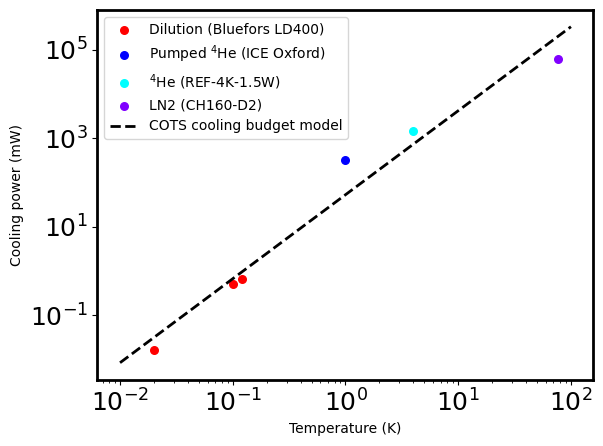

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Scatter plots
plt.scatter(0.02, 0.016, 30, color='r', marker='o', edgecolor='r', alpha=1)
plt.scatter(1, 320, 30, color='b', marker='o', edgecolor='b', alpha=1)
plt.scatter(4, 1500, 30, color=[0, 1, 1], marker='o', edgecolor=[0, 1, 1], alpha=1)
plt.scatter(77, 63000, 30, color=[0.5, 0, 1], marker='o', edgecolor=[0.5, 0, 1], alpha=1)

# Line plot
x0 = np.arange(-2, 2.1, 0.1)
x1 = 10 ** x0
plt.plot(x1, 10 ** (1.9 * np.log10(x1) + 1.724), 'k--', linewidth=2) # fitted model by linear regression of the typical commercial available cryostate data

# More scatter plots
plt.scatter(0.1, 0.5, 30, color='r', marker='o', edgecolor='r', alpha=1)
plt.scatter(0.12, 0.65, 30, color='r', marker='o', edgecolor='r', alpha=1)

# Setting log scale for both axes
plt.xscale('log')
plt.yscale('log')

# Labels and legend
plt.xlabel('Temperature (K)')
plt.ylabel('Cooling power (mW)')
plt.legend(['Dilution (Bluefors LD400)', 'Pumped $^4$He (ICE Oxford)', '$^4$He (REF-4K-1.5W)', 'LN2 (CH160-D2)', 'COTS cooling budget model'])

# Setting font size and line width of the box
plt.gca().tick_params(axis='both', which='major', labelsize=18)
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)

# Show plot
plt.show()


Different thermal load in the cyrostat will affect the temperature which can reach in the cryo system. The more qubit in the same cryostat with large thermal budget will introducing the temperature increases that will change the spin coherence time that affect the quantum volume of the whole system. We develop a spin-coherence model to estimate the potential change of the spin coherence time as the changing of the temperature.

$1/T_1=\Gamma_{ph}(T)/2\pi$

$\Gamma_{ph}(T) \propto \frac{\Delta_g^3}{e^{\hbar \Delta_g/k_B T}-1}$

$\Delta_g$ is the ground state splitting, which is 850GHz if no strain applied to a SnV$^-$.

Here we provide a plot about different color center due to a different spin plitting number for their $T_1$ comparing to different temperature. $^{[1]}$

[1]. Rosenthal, Eric I., et al. "Microwave spin control of a tin-vacancy qubit in diamond." Physical Review X 13.3 (2023): 031022.


<ipython-input-1-138412e4e87f>:14: RuntimeWarning: overflow encountered in exp
  yPbV = (4400/850)**3 * (np.exp(40.8 * 4400 / 850 / x) - 1) / 4.35 * 1e-13


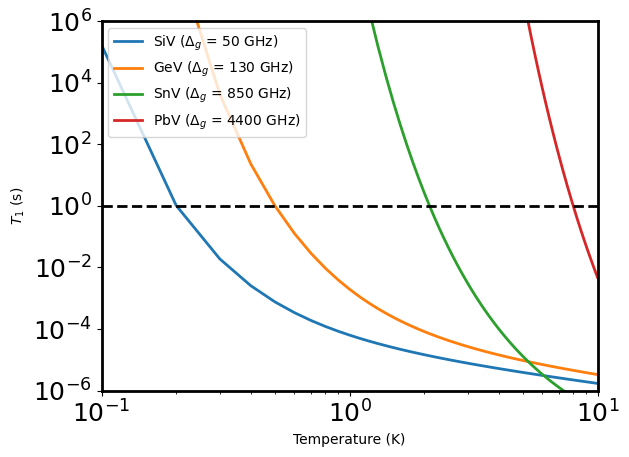

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create a new figure
plt.figure(2)

# Define x range
x = np.arange(0.1, 10.1, 0.1)

# Calculating y values for different curves
ySiV = (50/850)**3 * (np.exp(40.8 * 50 / 850 / x) - 1) / 3.24 * 1e-1
yGeV = (130/850)**3 * (np.exp(40.8 * 130 / 850 / x) - 1) / 9.396 * 1e-2
ySnV = (np.exp(40.8 / x) - 1) / 2.7 * 1e-8
yPbV = (4400/850)**3 * (np.exp(40.8 * 4400 / 850 / x) - 1) / 4.35 * 1e-13

# Plotting
plt.plot(x, ySiV, linewidth=2)
plt.plot(x, yGeV, linewidth=2)
plt.plot(x, ySnV, linewidth=2)
plt.plot(x, yPbV, linewidth=2)

# Adding a horizontal line
plt.axhline(y=1, color='k', linestyle='--', linewidth=2)

# Setting the legend
plt.legend(['SiV ($\Delta_g$ = 50 GHz)', 'GeV ($\Delta_g$ = 130 GHz)', 'SnV ($\Delta_g$ = 850 GHz)', 'PbV ($\Delta_g$ = 4400 GHz)'])

# Setting xticks
plt.xticks([0.1, 0.2, 0.5, 1, 2, 5, 10], ['0.1', '0.2', '0.5', '1', '2', '5', '10'])


# Setting the limits and scale of the axes
plt.ylim([1e-6, 1e6])
plt.xlim([0.1, 10])
plt.xscale('log')
plt.yscale('log')

# Setting font size and line width of the box
plt.gca().tick_params(axis='both', which='major', labelsize=18)
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)

# Adding labels
plt.xlabel('Temperature (K)')
plt.ylabel('$T_1$ (s)')

# Show plot
plt.show()


And here $T_2$ has a limited restriction to be 2$T_1$. And reference has realized experimentally for $T_2=0.53T_1$ for the NV center in diamond with optimized dynamic decoupling sequence. $^{[1]}$. So here we are using a assumption of the best $T_2$ value we can reach by microwave control sequence optimization and material purification as $T_{2m}=0.5T_1$ to estimate the potential $QV_{max}$ in the system.

[1]. Bar-Gill, Nir, et al. "Solid-state electronic spin coherence time approaching one second." Nature communications 4.1 (2013): 1743.

**7. Emitter statistical data**

Use the emitter data from the github repo: https://github.com/LinsenLi97/Freely-scalable-architecture-modeling



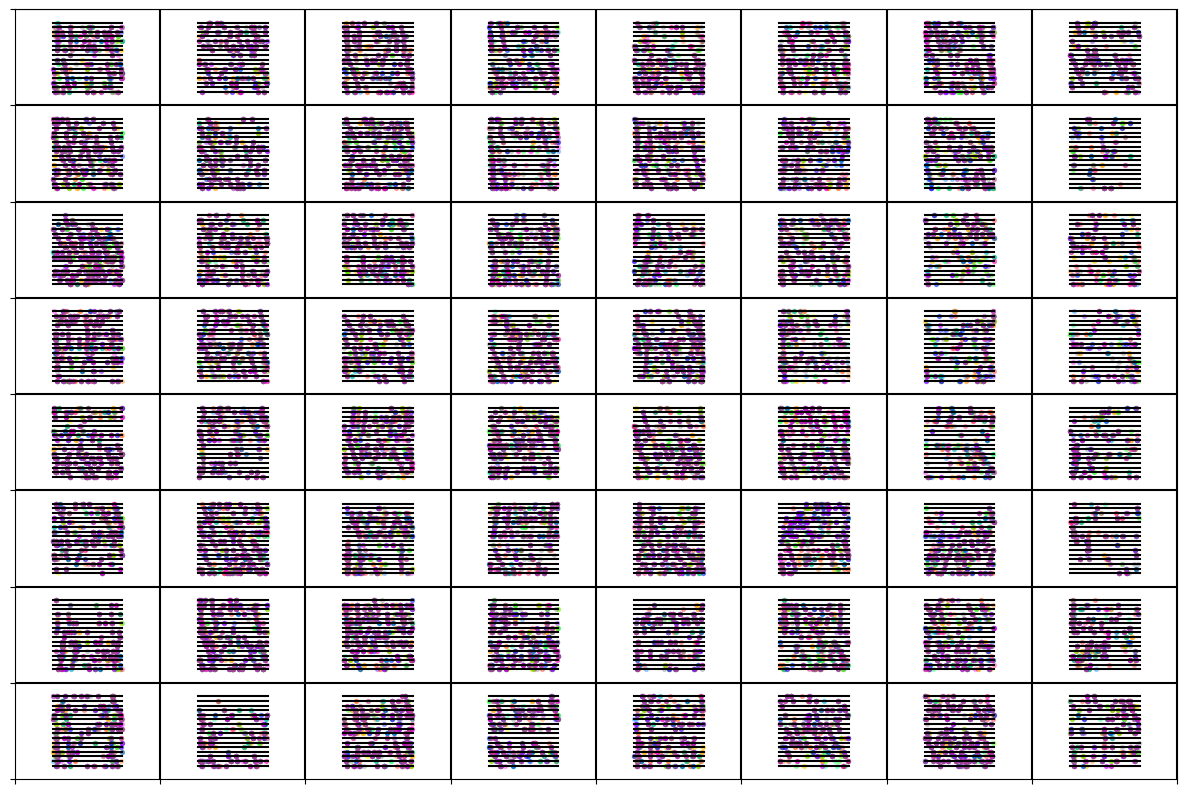

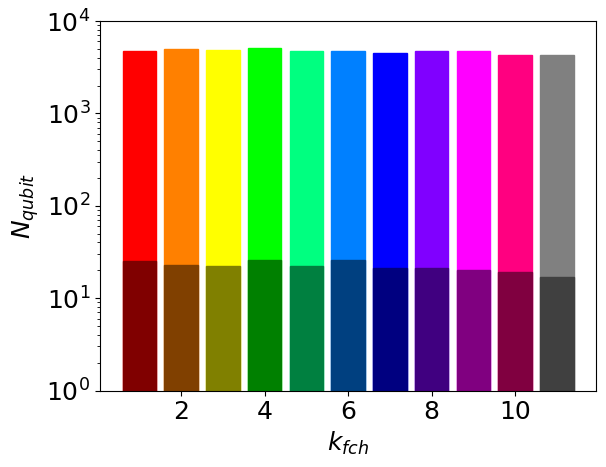

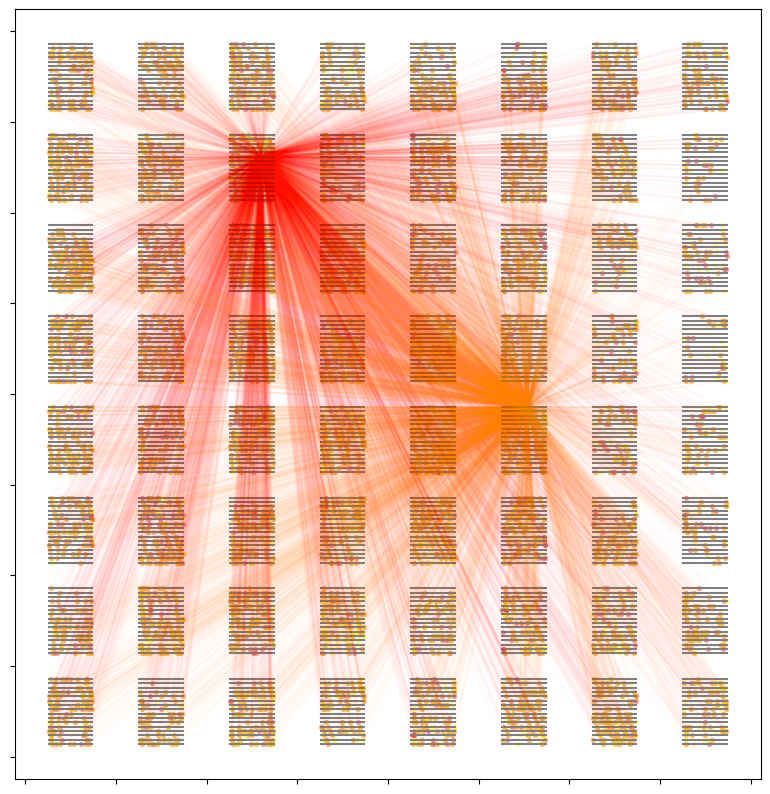

In [ ]:
# !pip install requests
# import requests

import scipy.io
import numpy as np
import matplotlib.pyplot as plt

# def download_file_from_google_drive(id, destination):
#     URL = "https://docs.google.com/uc?export=download"

#     session = requests.Session()

#     response = session.get(URL, params={'id': id}, stream=True)
#     token = get_confirm_token(response)

#     if token:
#         params = {'id': id, 'confirm': token}
#         response = session.get(URL, params=params, stream=True)

#     save_response_content(response, destination)

# def get_confirm_token(response):
#     for key, value in response.cookies.items():
#         if key.startswith('download_warning'):
#             return value

#     return None

# def save_response_content(response, destination):
#     CHUNK_SIZE = 32768

#     with open(destination, "wb") as f:
#         for chunk in response.iter_content(CHUNK_SIZE):
#             if chunk:  # filter out keep-alive new chunks
#                 f.write(chunk)

# file_id = '1N3C0J81R5YQmvyEg3wuTSXchvM-O_92I'  # Replace with your file ID
# destination = 'emitter_sumdata2.mat'
# download_file_from_google_drive(file_id, destination)

# Load the .mat file
# (https://drive.google.com/file/d/1N3C0J81R5YQmvyEg3wuTSXchvM-O_92I/view?usp=sharing)
# !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1N3C0J81R5YQmvyEg3wuTSXchvM-O_92I' -O emitter_sumdata.mat

mat_data = scipy.io.loadmat('emitter_stats_data.mat')
sumdata = mat_data['sumdata'][0]

# Initialize color array
c0 = np.array([
    [1, 0, 0],
    [1, 0.5, 0],
    [1, 1, 0],
    [0, 1, 0],
    [0, 1, 0.5],
    [0, 0.5, 1],
    [0, 0, 1],
    [0.5, 0, 1],
    [1, 0, 1],
    [1, 0, 0.5],
    [0.5, 0.5, 0.5]
])

# Plot setup
plt.figure(figsize=(15, 10))
# plt.hold(True)

# Draw lines
for i in range(1, 17):
    for j in range(1, 9):
        for k in range(1, 9):
            plt.plot([16.25 + 62.5 * (k - 1), 46.25 + 62.5 * (k - 1)],
                     [8.75 + (i - 1) * 3 + (j - 1) * 62.5, 8.75 + (i - 1) * 3 + (j - 1) * 62.5],
                     color='k')

# Scatter plot for each category in sumdata
for l in range(11):
    xall = []
    yall = []
    for info in sumdata[l]['info']:
        n = info[0] - 1
        i1 = n % 16
        i2 = (n % 128) // 16
        i3 = n // 128
        xc = info[1] * 30 + 16.25 + 62.5 * i3
        yc = 8.75 + i1 * 3 + i2 * 62.5
        xall.append(xc)
        yall.append(yc)

    plt.scatter(xall, yall, s=8, color=c0[l], alpha=0.3)

# Setting the ticks
plt.xticks([0, 62.5, 125, 187.5, 250, 312.5, 375, 437.5, 500], [])
plt.yticks([0, 62.5, 125, 187.5, 250, 312.5, 375, 437.5, 500], [])

# Draw grid lines
for i in range(1, 9):
    plt.plot([62.5 * i, 62.5 * i], [0, 500], color='k')
    plt.plot([0, 500], [62.5 * i, 62.5 * i], color='k')

plt.box(on=True)
plt.ylim([0, 500])
plt.xlim([0, 500])
plt.show()

import matplotlib.pyplot as plt
import numpy as np

# Data
dnum = np.array([25, 23, 22, 26, 22, 26, 21, 21, 20, 19, 17])
newbar4 = np.array([4696, 4968, 4793, 5066, 4710, 4770, 4459, 4671, 4754, 4306, 4306])
# Assuming c0 is an array of RGB color values
# c0 = np.array([[...], [...], ...])  # Replace with actual RGB values

# Create the figure and axes
plt.figure(3)
ax = plt.gca()

# plt.bar(np.arange(1, 12), newbar4,c0)
# plt.bar(np.arange(1, 12), dnum,c0)

# Plotting the first bar chart
nb = ax.bar(np.arange(1, 12), newbar4)
for k, bar in enumerate(nb):
    bar.set_color(c0[k])

# # Plotting the second bar chart
nb2 = ax.bar(np.arange(1, 12), dnum)
for k, bar in enumerate(nb2):
    bar.set_color(c0[k] * 0.5)

# Set y-axis to logarithmic scale
ax.set_yscale('log')

# Set box style and font size
# ax.box_on()
ax.tick_params(labelsize=18)
plt.ylim([1, 1e4])

plt.xlabel('$k_{fch}$',fontsize=18)
plt.ylabel('$N_{qubit}$',fontsize=18)
plt.show()


# Create figure
plt.figure(figsize=(15, 10))
plt.gca().set_aspect('equal', adjustable='box')

# Nested loops for line drawing
for i in range(1,17):
    for j in range(1,9):
        for k in range(1,9):
            plt.plot([16.25 + 62.5 * (k - 1), 46.25 + 62.5 * (k - 1)],
                     [8.75 + (i - 1) * 3 + (j - 1) * 62.5, 8.75 + (i - 1) * 3 + (j - 1) * 62.5],
                     color=[0.5, 0.5, 0.5])

# Assuming sumdata is a list of objects/dictionaries
# Replace this with the appropriate handling of sumdata
sumdata2 = sumdata.copy()

# Scatter plot
for l in range(1):
    xall, yall = [], []
    for info in sumdata[l]['info']:
        n = info[0] - 1
        i1, i2, i3 = n % 16, (n % 128) // 16, n // 128
        xc, yc = info[1] * 30 + 16.25 + 62.5 * i3, 8.75 + i1 * 3 + i2 * 62.5
        xall.append(xc)
        yall.append(yc)
    sumdata2[l]['info'] = np.column_stack((sumdata[l]['info'], xall, yall))
    plt.scatter(xall, yall, 8, color=c0[l], alpha=0.3)  # c0 needs to be defined

# Draw additional lines
for i in range(len(xall)):
    plt.plot([xall[2000], xall[i]], [yall[2000], yall[i]], color=[1, 0, 0, 0.02])

l = 2
xall2, yall2 = [], []
for info in sumdata[l]['info']:
    n = info[0] - 1
    i1, i2, i3 = n % 16, (n % 128) // 16, n // 128
    xc, yc = info[1] * 30 + 16.25 + 62.5 * i3, 8.75 + i1 * 3 + i2 * 62.5
    xall2.append(xc)
    yall2.append(yc)
# sumdata2[l]['info'] = np.column_stack((sumdata[l]['info'], xall, yall))
plt.scatter(xall2, yall2, 8, color=c0[l], alpha=0.3)  # c0 needs to be defined

# Draw additional lines
for i in range(len(xall)):
    plt.plot([xall2[3700], xall2[i]], [yall2[3700], yall2[i]], color=[1, 0.5, 0, 0.02])

# Set ticks and labels
plt.xticks([0, 62.5, 125, 187.5, 250, 312.5, 375, 437.5, 500], [])
plt.yticks([0, 62.5, 125, 187.5, 250, 312.5, 375, 437.5, 500], [])

plt.show()


